Now, this is the second part of the project. This part consists in evaluate the architecture of the first colab with a trickier dataset. This dataset is FER2013 dataset which is based in images of people with different emotions.
We're going to do the same, add some noise, train the model and let's see what happens.

Afterwars, we're going to create a home made UNET model in order to train it with this dataset and compare the results. The UNET model is copy and paste because we don't care about the tecnical part.

First, we have to setup Kaggle API to download the dataset in csv in format.

In [ ]:
import os

# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge


kaggle.json
/content/data
 94% 73.0M/77.3M [00:01<00:00, 32.1MB/s]
100% 77.3M/77.3M [00:01<00:00, 44.6MB/s]
 75% 69.0M/92.0M [00:01<00:00, 59.5MB/s]
100% 92.0M/92.0M [00:01<00:00, 79.1MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 6.75MB/s]
 88% 17.0M/19.3M [00:00<00:00, 39.3MB/s]
100% 19.3M/19.3M [00:00<00:00, 39.3MB/s]
 75% 72.0M/96.6M [00:00<00:00, 89.0MB/s]
100% 96.6M/96.6M [00:00<00:00, 152MB/s] 


In [ ]:
# Unzip data
!unzip train.csv.zip train.csv
!unzip test.csv.zip test.csv

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


Once we have the data, we import the libraries and load the data with pandas.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'

train_data = pd.read_csv(train_path, header=0, na_filter=False)
test_data = pd.read_csv(test_path, header=0, na_filter=False)

print(train_data.shape[0])
print(train_data.head(10))
print(test_data.shape[0])
print(test_data.head(10))

28709
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
9        2  255 254 255 254 254 179 122 107 95 124 149 150...
7178
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102

Let's see how balanced is the dataset.

In [ ]:
train_data['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

We can see that the amount of data of emotion 3(happy), 6(neutral) and 4(sad) is bigger than the rest. This may affect to our results but we'll try it like this.

In [ ]:
X_train = train_data.loc[:, 'pixels']
X_test = test_data.loc[:, 'pixels']

Y_train = train_data.loc[:, 'emotion']


print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)

(28709,)
(7178,)
(28709,)


Split the train data into two sets: new train data and validation data.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(X_train, Y_train, test_size=7000, shuffle=True)

print(x_train.shape)
print(x_validation.shape)

(21709,)
(7000,)


All the values are strings, so we have to change the value of each pixel to int.

In [ ]:
x_train_list = []
x_validation_list = []
x_test_list = []
j=0
for i in x_train:
  i = i.split(" ")
  x_train_list.append([int(k) for k in i])  

j=0
for i in x_validation:
  i = i.split(" ")
  x_validation_list.append([int(k) for k in i])  

j=0
for i in X_test:
  i = i.split(" ")
  x_test_list.append([int(k) for k in i])  


x_train_np = np.asarray(x_train_list)
x_validation_np = np.asarray(x_validation_list)
x_test_np = np.asarray(x_test_list)

print(x_train_np.shape)
print(x_validation_np.shape)
print(x_test_np.shape)

(21709, 2304)
(7000, 2304)
(7178, 2304)


Preprocess data: normalization between 0 and 1, reshape.
Also, create the noisy dataset with noise_factor = 1.

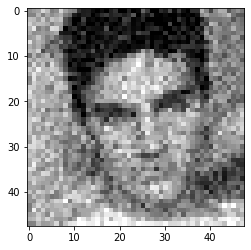

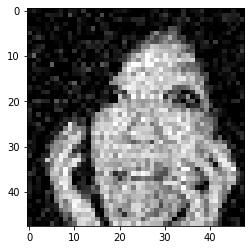

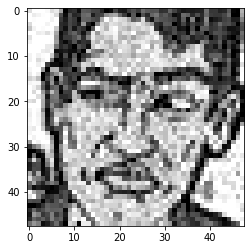

<Figure size 432x288 with 0 Axes>

In [ ]:
x_train = x_train_np.astype('float32') / 255
x_validation = x_validation_np.astype('float32') / 255
x_test = x_test_np.astype('float32') / 255

x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))
x_validation = np.reshape(x_validation, (len(x_validation), 48, 48, 1))
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))

noise_factor = 0.1
#we choose loc = 0 and scale = 1. We add noise to the original images.
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_validation_noisy = x_validation + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_validation.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

#limit the values between 0 and 1.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validation_noisy = np.clip(x_validation_noisy, 0., 1.)
x_test_small_noisy = np.clip(x_test_noisy, 0., 1.)

plt.imshow(x_train_noisy[0].reshape(48,48))
plt.show()
plt.imshow(x_validation_noisy[0].reshape(48,48))
plt.show()
plt.imshow(x_test_small_noisy[0].reshape(48,48))
plt.show()
plt.gray()

Create the model of the simple autoencoder.

In [ ]:
#input layer
input = tf.keras.layers.Input(shape=(48, 48, 1))

#encoder
layer1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
layer2 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(layer1)
layer3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(layer2)
encoder = tf.keras.layers.MaxPool2D((2, 2), padding='same')(layer3)

#decoder
layer4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
layer5 = tf.keras.layers.UpSampling2D((2, 2))(layer4)
layer6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(layer5)
layer7 = tf.keras.layers.UpSampling2D((2, 2))(layer6)
decoder = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer7)

#sigmoid function to range the output between 0 and 1.

autoencoder = tf.keras.Model(input, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 24, 24, 32)        0   

Train the autoencoder with noisy data and original data as labels.

In [ ]:
model = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128,
                  shuffle=True, validation_data=(x_validation_noisy, x_validation))

Epoch 1/100
170/170 [==============================] - 37s 20ms/step - loss: 0.6061 - accuracy: 0.0149 - val_loss: 0.5643 - val_accuracy: 0.0160
Epoch 2/100
170/170 [==============================] - 3s 17ms/step - loss: 0.5629 - accuracy: 0.0165 - val_loss: 0.5608 - val_accuracy: 0.0160
Epoch 3/100
170/170 [==============================] - 3s 17ms/step - loss: 0.5602 - accuracy: 0.0162 - val_loss: 0.5594 - val_accuracy: 0.0160
Epoch 4/100
170/170 [==============================] - 3s 17ms/step - loss: 0.5587 - accuracy: 0.0165 - val_loss: 0.5594 - val_accuracy: 0.0161
Epoch 5/100
170/170 [==============================] - 3s 17ms/step - loss: 0.5584 - accuracy: 0.0159 - val_loss: 0.5587 - val_accuracy: 0.0161
Epoch 6/100
170/170 [==============================] - 3s 17ms/step - loss: 0.5580 - accuracy: 0.0159 - val_loss: 0.5576 - val_accuracy: 0.0161
Epoch 7/100
170/170 [==============================] - 3s 17ms/step - loss: 0.5573 - accuracy: 0.0166 - val_loss: 0.5572 - val_accuracy

Show the figures of the training.

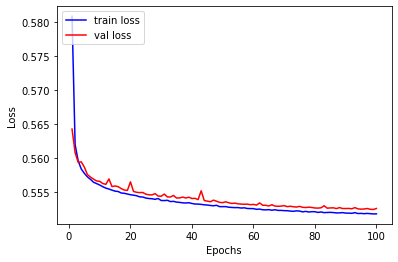

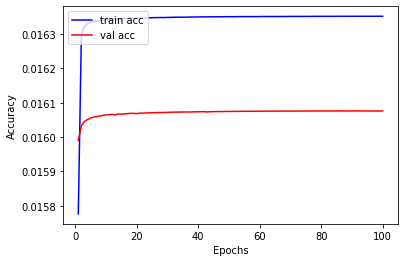

In [ ]:
loss_train = model.history['loss']
accuracy_train = model.history['accuracy']
loss_val = model.history['val_loss']
accuracy_val = model.history['val_accuracy']

t = np.linspace(1, 100, 100)

plt.plot(t, loss_train, "-b", label="train loss")
plt.plot(t, loss_val, "-r", label="val loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(t, accuracy_train, "-b", label="train acc")
plt.plot(t, accuracy_val, "-r", label="val acc")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Now, we compare the results between the original data (without noise) and the predicted data. Afterwards, we compare the noisy data with the predicted data.

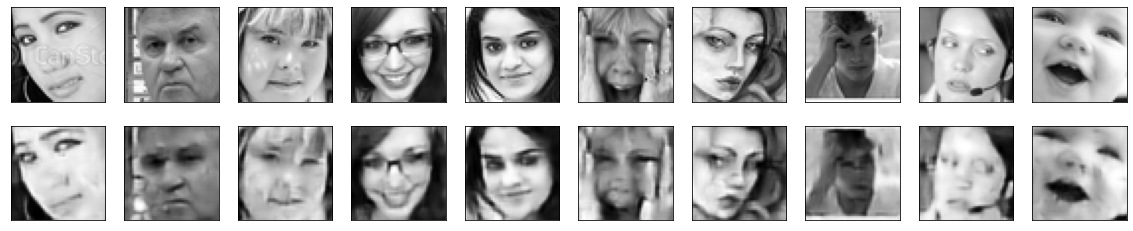

In [ ]:
#predictions
pred = autoencoder.predict(x_test_small_noisy)

#visualizating the predictions
samples = 10
plt.figure(figsize=(20, 4))

for i in range(1, samples + 1):
  #original image
  ax = plt.subplot(2, samples, i)
  plt.imshow(x_test[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, samples, i + samples)
  plt.imshow(pred[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

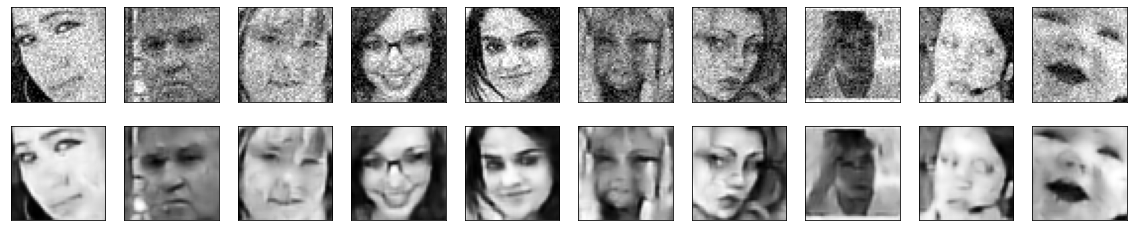

In [ ]:
samples = 10
plt.figure(figsize=(20, 4))
for i in range(1, samples + 1):
  #original image
  ax = plt.subplot(2, samples, i)
  plt.imshow(x_test_small_noisy[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, samples, i + samples)
  plt.imshow(pred[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Structural Similarity Index

In order to compare images the best error we can use is the structural similarity index. If the 2 images are the same, the value that returns this error is 1.

In [ ]:
from skimage.measure import compare_ssim, compare_psnr
from skimage import data, img_as_float

compare_ssim(x_test, pred, multichannel=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


0.9690652522155612

The results are not extremely bad, but the images are blurred. Let's create the UNET model.

In [ ]:
def build_model(input_layer, start_neurons):
    conv1 = tf.keras.layers.Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
    conv1 = tf.keras.layers.Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.25)(pool1)
    
    conv2 = tf.keras.layers.Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.5)(pool2)

    conv3 = tf.keras.layers.Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.5)(pool3)
    
    conv4 = tf.keras.layers.Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.5)(pool4)

    #Middle
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)
    
    #upconv part
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(0.5)(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(0.5)(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    
    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
    uconv2 = tf.keras.layers.Dropout(0.5)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    
    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(uconv1)
    return output_layer

In [ ]:
input_layer = tf.keras.layers.Input((48, 48,1))
output_layer = build_model(input_layer, 64)


model_unet = tf.keras.Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')

Let's train the model.

In [ ]:
model = model_unet.fit(x_train_noisy, x_train, epochs=35, batch_size=64,
                  shuffle=True, validation_data=(x_validation_noisy, x_validation))

Epoch 1/35
340/340 [==============================] - 121s 355ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/35
340/340 [==============================] - 121s 357ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 3/35
340/340 [==============================] - 121s 357ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/35
340/340 [==============================] - 122s 358ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/35
340/340 [==============================] - 122s 359ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/35
340/340 [==============================] - 122s 358ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/35
340/340 [==============================] - 121s 357ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/35
340/340 [==============================] - 121s 357ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/35
340/340 [==============================] - 122s 358ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/35
340/340 [==============================] - 121s 357m

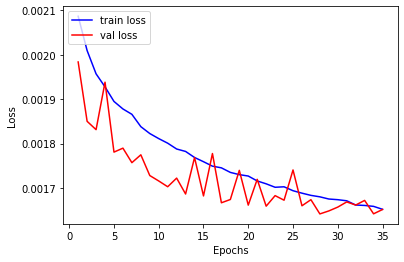

In [ ]:
loss_train = model.history['loss']
loss_val = model.history['val_loss']

t = np.linspace(1, 35, 35)

plt.plot(t, loss_train, "-b", label="train loss")
plt.plot(t, loss_val, "-r", label="val loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Prediction.

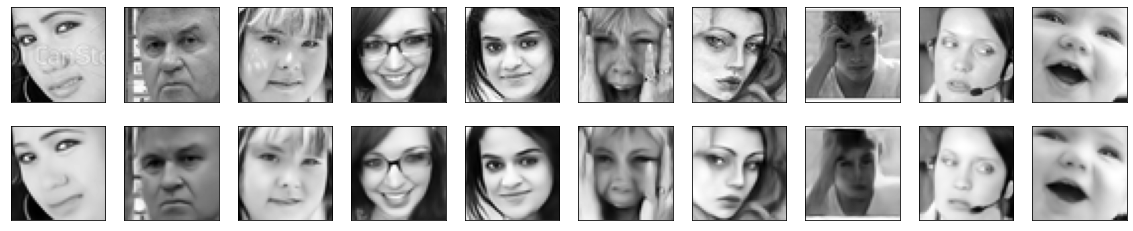

In [ ]:
#predictions
pred_unet = model_unet.predict(x_test_small_noisy)

#visualizating the predictions
samples = 10
plt.figure(figsize=(20, 4))

for i in range(1, samples + 1):
  #original image
  ax = plt.subplot(2, samples, i)
  plt.imshow(x_test[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, samples, i + samples)
  plt.imshow(pred_unet[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

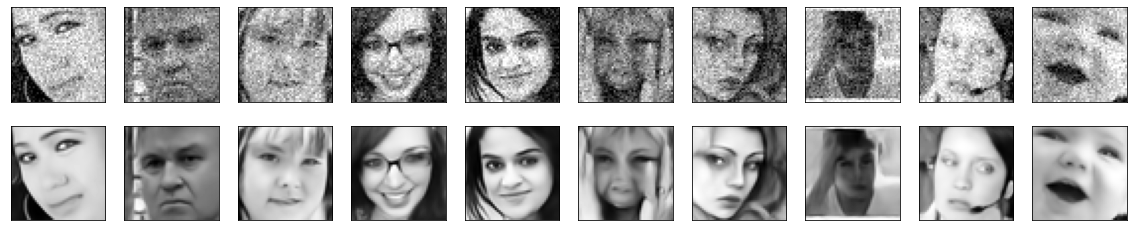

In [ ]:
samples = 10
plt.figure(figsize=(20, 4))
for i in range(1, samples + 1):
  #original image
  ax = plt.subplot(2, samples, i)
  plt.imshow(x_test_small_noisy[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, samples, i + samples)
  plt.imshow(pred_unet[i].reshape(48, 48))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from skimage.measure import compare_ssim, compare_psnr
from skimage import data, img_as_float

compare_ssim(x_test, pred_unet, multichannel=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


0.9814382667256473

In conclusion, we can see how U-Net is capable of remove all the noise from the images. The results are really good, maybe the predicted images are a little bit blurred, but the results are so good.

Now, the last part of this project is to evaluate a SOTA method that uses the U-Net architecture with a bigger dataset from SpainAI.